In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tools import *
import urllib.request
from PIL import Image
import numpy as np
import requests
import rasterio
from io import BytesIO
import seaborn as sns


In [2]:
ee.Authenticate()
ee.Initialize()

In [56]:
# ROI - Region of Interest
lon, lat = -99.11, 19.43  # CDMX
width, height = 0.75, 0.75
region = ee.Geometry.Rectangle([lon+width, lat+height, lon-width, lat-height])

# Time range
t1_a, t1_b = '2024-02-01', '2024-02-14'
t2_a, t2_b = '2024-09-01', '2024-09-15'
tt_a, tt_b = '2024-02-01', '2024-10-30'
tt = [
    ('2024-01-01', '2024-06-30'), 
    ('2024-07-01', '2024-12-31'),
    ('2023-01-01', '2023-06-30'),
    ('2023-07-01', '2023-12-31'),
    ('2022-01-01', '2022-06-30'),
    ('2022-07-01', '2022-12-31'),
    ('2021-01-01', '2021-06-30'),
    ('2021-07-01', '2021-12-31'),
    ('2020-01-01', '2020-06-30'),
    ('2020-07-01', '2020-12-31'),
]



In [57]:
aai = Collection(
    'COPERNICUS/S5P/OFFL/L3_AER_AI', 
    'absorbing_aerosol_index',
    region,
    tt_a, tt_b
)
co = Collection(
    'COPERNICUS/S5P/OFFL/L3_CO', 
    'CO_column_number_density',
    region,
    tt_a, tt_b,
    scale=1e6,
    new_name='rescaled_CO'
)
no2 = Collection(
    'COPERNICUS/S5P/OFFL/L3_NO2', 
    'tropospheric_NO2_column_number_density',
    region,
    tt_a, tt_b,
    scale=None,
    new_name='rescaled_NO2'
)
prec = Collection(
    'UCSB-CHG/CHIRPS/DAILY', 
    'precipitation',
    region,
    tt_a, tt_b,
    scale=None,
    new_name='rescaled_prec'
)

In [58]:
co.get_event(t1_a, t1_b, 'event_co_t1')
co.get_event(t2_a, t2_b, 'event_co_t2')
co.set_viz_params({'min': 0, 'max': 50000/(1e6), 'unit': 'mol/m²','value': 'CO',
                   'palette': ['black','blue','purple','cyan','green','yellow','red']})
aai.get_event(t1_a, t1_b, 'event_aai_t1')
aai.get_event(t2_a, t2_b, 'event_aai_t2')
aai.set_viz_params({'min': -1, 'max': 2, 'unit': '-','value': 'absorbing_aerosol_index',
                   'palette': ['black','blue','purple','cyan','green','yellow','red']})
no2.get_event(t1_a, t1_b, 'event_no2_t1')
no2.get_event(t2_a, t2_b, 'event_no2_t2')
no2.set_viz_params({'min': 0, 'max': 5e-5, 'unit': 'mol/m²','value': 'NO2',
                   'palette': ['black','blue','purple','cyan','green','yellow','red']})
prec.get_event(t1_a, t1_b, 'event_prec_t1')
prec.get_event(t2_a, t2_b, 'event_prec_t2')
prec.set_viz_params({'min': 0, 'max': 15, 'unit': 'mm','value': 'precipitation',
                   'palette': ['white','lightblue','blue','darkblue']})

/home/map10194/Documents/monitoring_cities/tools.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


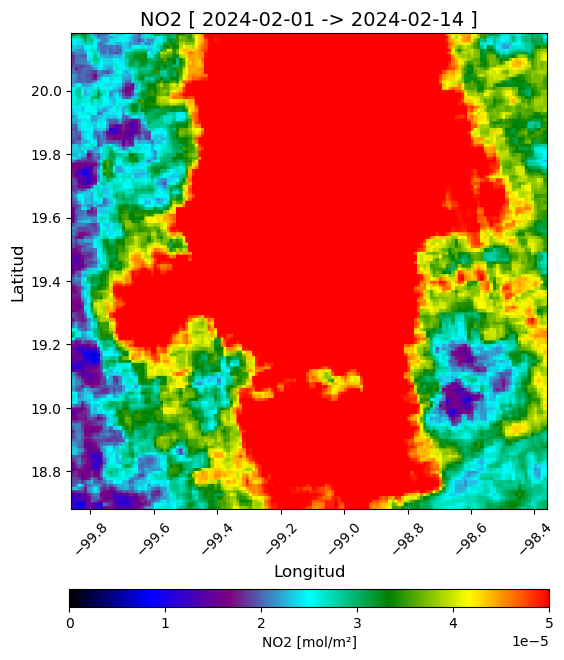

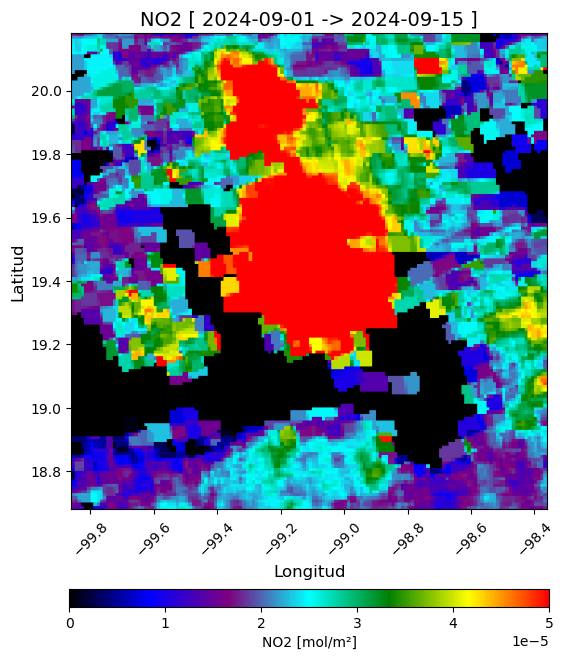

In [63]:
no2.plot_event('event_no2_t1','NO2 [ 2024-02-01 -> 2024-02-14 ]', legend_label=True)
no2.plot_event('event_no2_t2','NO2 [ 2024-09-01 -> 2024-09-15 ]', legend_label=True)

/home/map10194/Documents/monitoring_cities/tools.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


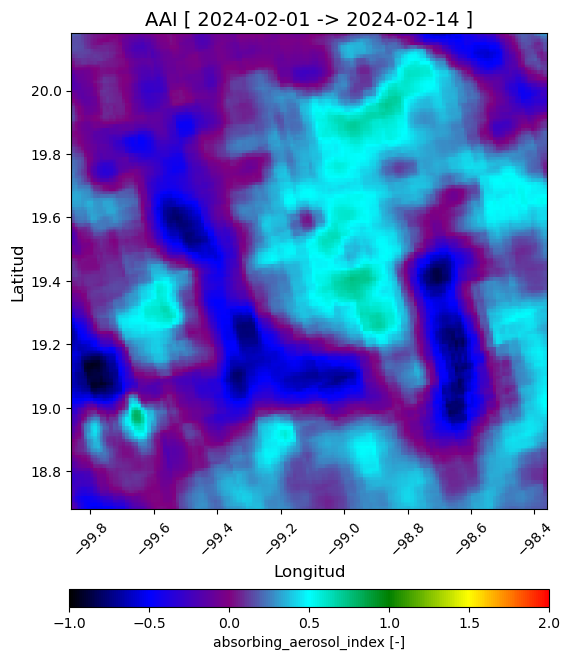

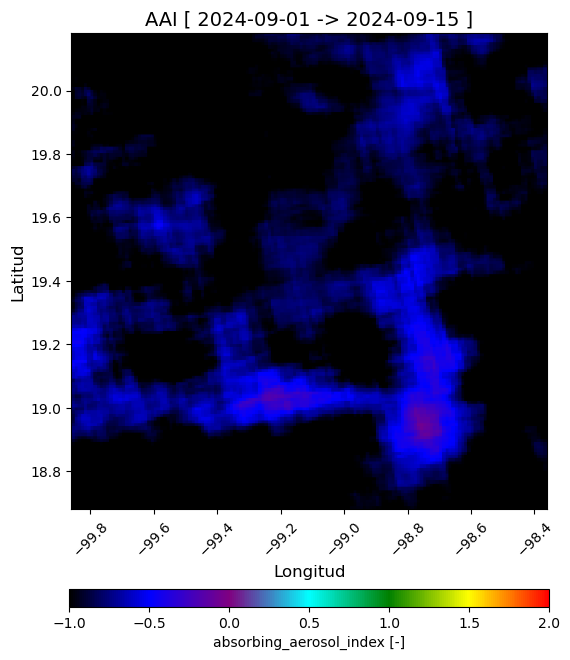

In [64]:
aai.plot_event('event_aai_t1','AAI [ 2024-02-01 -> 2024-02-14 ]', legend_label=True)
aai.plot_event('event_aai_t2','AAI [ 2024-09-01 -> 2024-09-15 ]', legend_label=True)

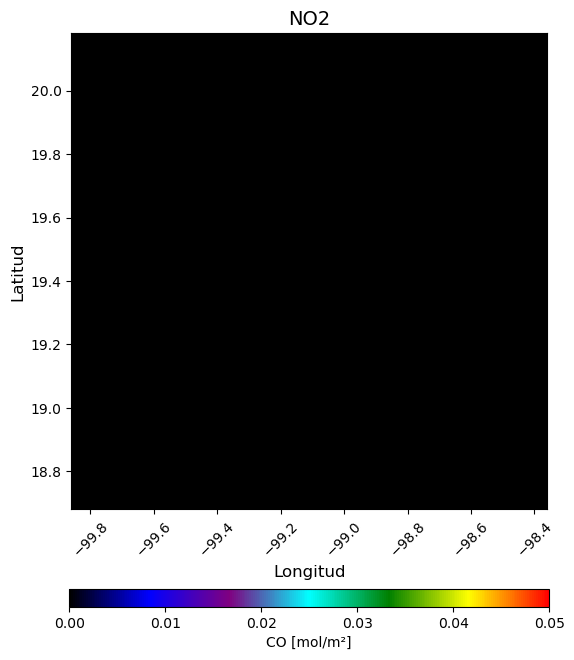

In [55]:
co.plot_event('event_co_t1','NO2', legend_label=True)

In [7]:
# prec.plot_timeseries()

In [8]:
dfs = []
for start, end in tt:
    co = Collection(
        'COPERNICUS/S5P/OFFL/L3_CO', 
        'CO_column_number_density',
        region,
        start, end,
        scale=1e6,
        new_name='rescaled_CO'
    )
    temp_df_co = co.to_timeseries_df()
    aai = Collection(
        'COPERNICUS/S5P/OFFL/L3_AER_AI', 
        'absorbing_aerosol_index',
        region,
        start, end,
    )
    temp_df_aai = aai.to_timeseries_df()
    no2 = Collection(
        'COPERNICUS/S5P/OFFL/L3_NO2', 
        'tropospheric_NO2_column_number_density',
        region,
        start, end,
        scale=None,
        new_name='rescaled_NO2'
    )
    temp_df_no2 = no2.to_timeseries_df()
    prec = Collection(
        'UCSB-CHG/CHIRPS/DAILY', 
        'precipitation',
        region,
        start, end,
        scale=None,
        new_name='rescaled_prec'
    )
    temp_df_prec = prec.to_timeseries_df()
    # Asegúrate de que la columna 'date' sea datetime
    temp_df_co['date'] = pd.to_datetime(temp_df_co['date'])
    temp_df_aai['date'] = pd.to_datetime(temp_df_aai['date'])
    temp_df_no2['date'] = pd.to_datetime(temp_df_no2['date'])
    temp_df_prec['date'] = pd.to_datetime(temp_df_prec['date'])
    # Combina los DataFrames en uno solo usando 'date' como clave

    df_all_ = temp_df_co.copy()

    # Merge por fecha
    df_all_ = df_all_.merge(temp_df_no2, on='date', how='outer')
    df_all_ = df_all_.merge(temp_df_aai, on='date', how='outer')
    df_all_ = df_all_.merge(temp_df_prec, on='date', how='outer')
    dfs.append(df_all_)
df_all = pd.concat(dfs, axis=0, ignore_index=True)
df_all = df_all.sort_values('date').reset_index(drop=True)

df_all.head()

,date,rescaled_CO,rescaled_NO2,absorbing_aerosol_index,rescaled_prec
0,2020-01-01,NaN,NaN,NaN,0.001159
1,2020-01-01,NaN,NaN,NaN,0.001159
2,2020-01-01,NaN,NaN,NaN,0.001159
3,2020-01-01,NaN,NaN,NaN,0.001159
4,2020-01-01,NaN,NaN,NaN,0.001159


In [9]:
# plt.plot(df_all['date'], df_all['rescaled_CO'], marker='.')

In [16]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['month'] = df_all['date'].dt.month
df_all.rename(columns={
    'rescaled_CO': 'CO',
    'rescaled_NO2': 'NO2',
    'absorbing_aerosol_index': 'AAI',
    'rescaled_prec': 'PREC'
}, inplace=True)
df_summary = df_all.groupby('month').agg({
    'CO': ['mean','std'],
    'NO2': ['mean','std'],
    'AAI': ['mean','std'],
    'PREC': ['mean','std']
}).reset_index()


In [11]:
# Promedio y desviación estándar por mes (ignorando año)
monthly_mean = df_all.groupby('month').mean(numeric_only=True)
monthly_std = df_all.groupby('month').std(numeric_only=True)

# Opcional: convertir índice a fechas tipo 1900-MM-01 para plot
monthly_mean.index = pd.to_datetime(monthly_mean.index, format='%m').to_period('M')
monthly_std.index = pd.to_datetime(monthly_std.index, format='%m').to_period('M')

monthly_mean
# monthly_std

,rescaled_CO,rescaled_NO2,absorbing_aerosol_index,rescaled_prec
month,,,,
1900-01,23783.425632,0.000069,-0.869486,0.233816
1900-02,24758.355663,0.000063,-0.716096,0.161311
1900-03,26944.678554,0.000055,-0.660320,0.293051
1900-04,30226.242764,0.000042,-0.846834,0.839618
1900-05,30975.853231,0.000042,-0.932356,2.103658
1900-06,24857.225905,0.000040,-0.978012,3.838255
1900-07,21365.050427,0.000038,-0.967243,6.074948
1900-08,21141.189865,0.000035,-1.025510,6.287289
1900-09,22514.693376,0.000035,-1.009622,5.911429


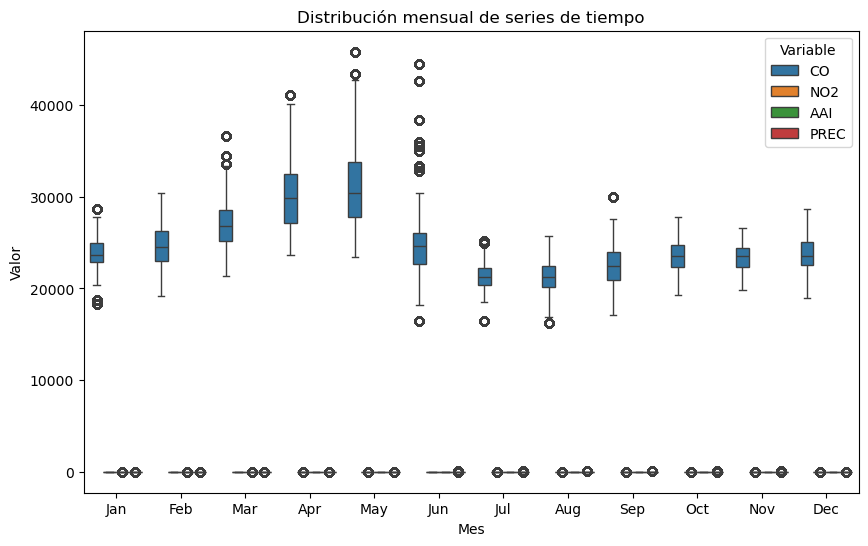

In [17]:

df_all['date'] = pd.to_datetime(df_all['date'])
df_all['month'] = df_all['date'].dt.month


df_long = df_all.melt(id_vars=['date','month'], var_name='variable', value_name='value')


plt.figure(figsize=(10,6))
sns.boxplot(x='month', y='value', hue='variable', data=df_long)
plt.xticks(range(0,12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('Valor')
plt.xlabel('Mes')
plt.title('Distribución mensual de series de tiempo')
plt.legend(title='Variable')
plt.show()

In [27]:
df_summary = df_all.groupby('month').agg({
    'CO': ['mean','std'],
    'PREC': ['mean','std'],
    'NO2': ['mean','std'],
    'AAI': ['mean','std']
}).reset_index()
df_summary.columns = ['month', 'CO_mean','CO_std','PREC_mean','PREC_std', 'NO2_mean','NO2_std','AAI_mean','AAI_std']


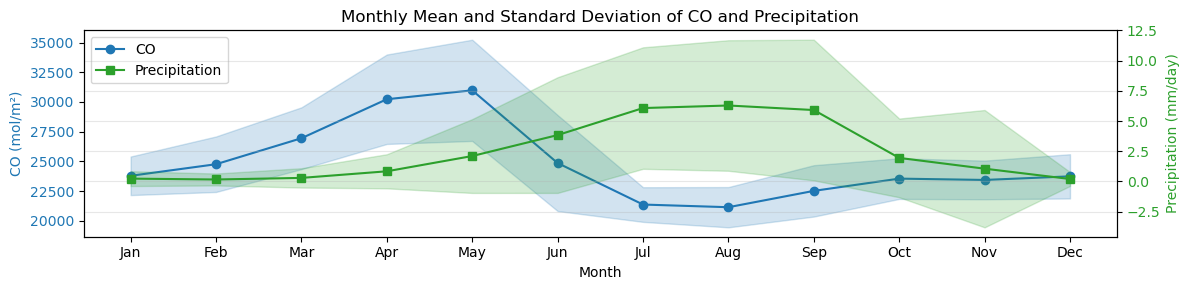

In [71]:
months = np.arange(1, 13)
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax1 = plt.subplots(figsize=(12,3))

# --- CO en eje izquierdo ---
color1 = 'tab:blue'
ax1.plot(months, df_summary['CO_mean'], color=color1, marker='o', label='CO')
ax1.fill_between(
    months,
    df_summary['CO_mean'] - df_summary['CO_std'],
    df_summary['CO_mean'] + df_summary['CO_std'],
    color=color1,
    alpha=0.2
)
ax1.set_xlabel('Month')
ax1.set_ylabel('CO (mol/m²)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(months)
ax1.set_xticklabels(month_labels)

# --- PREC en eje derecho ---
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.plot(months, df_summary['PREC_mean'], color=color2, marker='s', label='Precipitation')
ax2.fill_between(
    months,
    df_summary['PREC_mean'] - df_summary['PREC_std'],
    df_summary['PREC_mean'] + df_summary['PREC_std'],
    color=color2,
    alpha=0.2
)
ax2.set_ylabel('Precipitation (mm/day)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# --- Leyenda combinada ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Monthly Mean and Standard Deviation of CO and Precipitation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


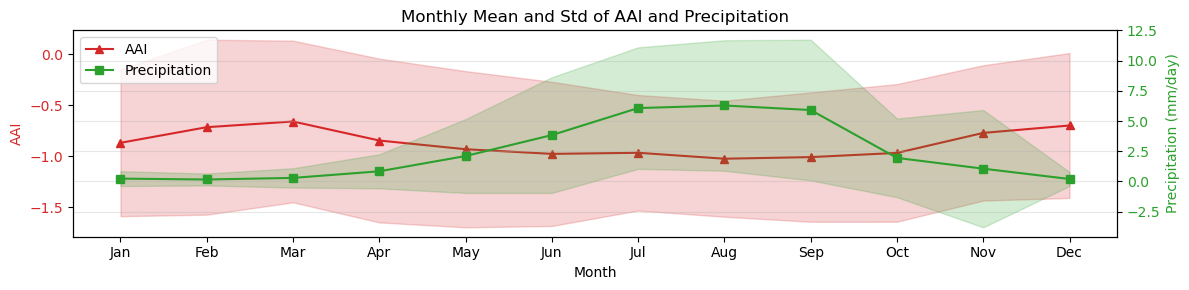

In [72]:
months = np.arange(1, 13)
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax1 = plt.subplots(figsize=(12,3))

# --- AAI en eje izquierdo ---
color1 = 'tab:red'
ax1.plot(months, df_summary['AAI_mean'], color=color1, marker='^', label='AAI')
ax1.fill_between(
    months,
    df_summary['AAI_mean'] - df_summary['AAI_std'],
    df_summary['AAI_mean'] + df_summary['AAI_std'],
    color=color1,
    alpha=0.2
)
ax1.set_xlabel('Month')
ax1.set_ylabel('AAI', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(months)
ax1.set_xticklabels(month_labels)

# --- PREC en eje derecho ---
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.plot(months, df_summary['PREC_mean'], color=color2, marker='s', label='Precipitation')
ax2.fill_between(
    months,
    df_summary['PREC_mean'] - df_summary['PREC_std'],
    df_summary['PREC_mean'] + df_summary['PREC_std'],
    color=color2,
    alpha=0.2
)
ax2.set_ylabel('Precipitation (mm/day)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# --- Leyenda combinada ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Monthly Mean and Std of AAI and Precipitation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


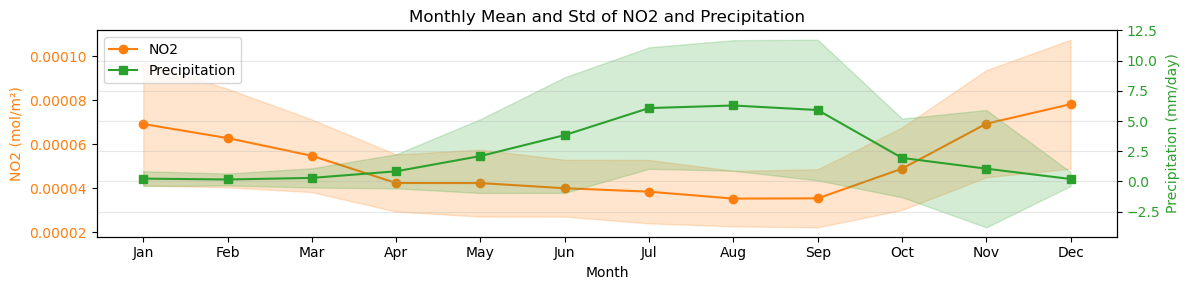

In [73]:
months = np.arange(1, 13)
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax1 = plt.subplots(figsize=(12,3))

# --- NO2 en eje izquierdo ---
color1 = 'tab:orange'
ax1.plot(months, df_summary['NO2_mean'], color=color1, marker='o', label='NO2')
ax1.fill_between(
    months,
    df_summary['NO2_mean'] - df_summary['NO2_std'],
    df_summary['NO2_mean'] + df_summary['NO2_std'],
    color=color1,
    alpha=0.2
)
ax1.set_xlabel('Month')
ax1.set_ylabel('NO2 (mol/m²)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(months)
ax1.set_xticklabels(month_labels)

# --- PREC en eje derecho ---
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.plot(months, df_summary['PREC_mean'], color=color2, marker='s', label='Precipitation')
ax2.fill_between(
    months,
    df_summary['PREC_mean'] - df_summary['PREC_std'],
    df_summary['PREC_mean'] + df_summary['PREC_std'],
    color=color2,
    alpha=0.2
)
ax2.set_ylabel('Precipitation (mm/day)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# --- Leyenda combinada ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Monthly Mean and Std of NO2 and Precipitation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
